In [2]:
import sys
sys.path.append("../")

from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from scipy import stats

from tqdm.notebook import tqdm

import random
import pickle

import seaborn as sns
# sns.set_palette("deep")
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.facecolor':'white'})
plt.rcParams["figure.facecolor"] = "white"

%matplotlib inline

%load_ext autoreload
%autoreload 2

from saccade_config import *

from eye_tracking.eye_tracking import get_stim_at_frame, get_saccade_magnitude_direction
from experiment.cre_line import match_cre_line

from analysis_helpers import load_data, load_data_by_session_id, savefig, heatmap_log_proba_plot, load_additional_data
from eye_plotting import STIM_ABBREV, STIM_COLORS, STIM_ORDERING

In [4]:
cells = load_additional_data(LOADED_CLASSIFIED_CELLS_CSV, in_data_dir=False, index_col=0)
CRE_PLOT_KEY = "cre_abbrev"
print(f"There are {len(cells):,} total cells.")
cells.head()

There are 32,442 total cells.


,cre_line,cre_abbrev,depth,targeted_structure,container_id,session_indices,response_classification,p_value,n_left,n_right,mean_left_response,mean_right_response,median_left_response,median_right_response,direction_selectivity,frac_left_significant,frac_right_significant,wilcoxon_signed_rank_p,ranksum_p_by_direction
specimen_id,,,,,,,,,,,,,,,,,,,
589170196,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 11), (510345479, 67), (510514474,...",0.0,0.148500,25.0,36.0,-0.005011,0.028588,-0.003895,-0.000737,1.425049,0.20,0.138889,0.378918,0.311603
517424547,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 109), (510345479, 68), (510514474...",0.0,0.849025,25.0,36.0,-0.008454,-0.002251,-0.013324,0.000459,-0.579440,0.20,0.166667,0.489899,0.472405
589170394,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 27), (510345479, 205), (510514474...",0.0,0.994925,25.0,36.0,-0.084782,-0.060959,-0.033635,0.006427,-0.163455,0.20,0.277778,0.245655,0.018225
589170745,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 6), (510345479, 206), (510514474,...",0.0,0.018600,25.0,36.0,0.133313,0.303742,-0.005347,0.017718,0.389949,0.24,0.194444,0.301768,0.713904
589170856,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,175.0,VISp,511510718.0,"((510174759, 9), (510345479, 22), (510514474, 9))",0.0,0.231125,25.0,36.0,-0.013324,0.014109,-0.006405,0.009928,34.951378,0.24,0.222222,0.893064,0.012153


In [16]:
# eval(cells.at[589170196, "session_indices"])

cell_to_sessions = {}
sessions_set = set()

for specimen_id in cells.index:
    session_indices = eval(cells.at[specimen_id, "session_indices"]) # NOTE: eval is used to parse a tuple from a string
    sessions = [session_id for session_id, cell_index in session_indices]
    cell_to_sessions[specimen_id] = sessions
    sessions_set.update(sessions)

print(f"There are {len(cell_to_sessions):,} cells across {len(sessions_set)} sessions.")

There are 32,442 cells across 735 sessions.


Load cell responses to saccades

In [5]:
save_file = r"/Users/chase/Desktop/saccade_responses_by_stim.pickle"
should_load_from_file = True

if should_load_from_file:
    with open(save_file, "rb") as file:
        cell_responses = pickle.load(file)
else:
    slice_after = slice(0, 10)
    slice_before = slice(-45, -15)
    cell_responses = []

    session_cache = {}

    for specimen_id in tqdm(cells.index[cells["response_classification"] != 0]):
        session_indices = eval(cells.at[specimen_id, "session_indices"])
        response_classification = cells.at[specimen_id, "response_classification"]
        is_ds = cells.at[specimen_id, "ranksum_p_by_direction"] < 0.05
        pref_dir = np.sign(cells.at[specimen_id, "direction_selectivity"])
        session_responses = []
        allowed_sacc_dir = None

        if response_classification == 1 and is_ds:
            allowed_sacc_dir = "R" if pref_dir == 1 else "L"


        for session_id, cell_index in session_indices:
            if session_id in session_cache:
                data = session_cache[session_id]
            else:
                full_data = load_data_by_session_id(session_id)
                eye_tracking = full_data["eye_tracking"]
                stim_epoch = full_data["stim_epoch"]
                data = {
                    "dff_traces": full_data["dff_traces"],
                    "saccades": []
                }
                for ss, se in full_data["saccades"]:
                    dir = get_direction_moved(eye_tracking, ss, se)
                    stim = get_stim_at_frame(stim_epoch, ss)
                    data["saccades"].append((ss, se, dir, stim))

                session_cache[session_id] = data
            
            dff = data["dff_traces"]
            responses = {}

            for ss, se, dir, stim in data["saccades"]:
                if allowed_sacc_dir is not None and dir != allowed_sacc_dir:
                    continue
                
                if stim not in responses:
                    responses[stim] = []
                
                response = dff[cell_index, (ss+slice_after.start):(ss+slice_after.stop)].mean() - dff[cell_index, (ss+slice_before.start):(ss+slice_before.stop)].mean()
                responses[stim].append(response)
            
            session_responses.append(responses)

        n_spontaneous_responses = [len(x["spontaneous"]) if "spontaneous" in x else 0 for x in session_responses]

        cell_responses.append({
            "specimen_id": specimen_id,
            "response_classification": response_classification,
            "allowed_sacc_dir": allowed_sacc_dir,
            "session_responses": session_responses,
            "n_spontaneous_responses": n_spontaneous_responses,
            CRE_PLOT_KEY: cells.at[specimen_id, CRE_PLOT_KEY],
            "targeted_structure": cells.at[specimen_id, "targeted_structure"],
        })

    del session_cache # Free up memory

    with open(save_file, "wb") as file:
        pickle.dump(cell_responses, file, protocol=pickle.HIGHEST_PROTOCOL)

T = 0: 3071 cells
T = 1: 2965 cells
T = 2: 2761 cells
T = 3: 2619 cells
T = 4: 2530 cells
T = 5: 2394 cells
T = 6: 2282 cells
T = 7: 2213 cells
T = 8: 2130 cells
T = 9: 2058 cells
T = 10: 1901 cells
T = 11: 1832 cells
T = 12: 1739 cells
T = 13: 1640 cells
T = 14: 1552 cells
T = 15: 1513 cells
T = 16: 1415 cells
T = 17: 1371 cells
T = 18: 1306 cells
T = 19: 1242 cells
T = 20: 1173 cells
T = 21: 1156 cells
T = 22: 1128 cells
T = 23: 1078 cells
T = 24: 1037 cells
T = 25: 995 cells


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


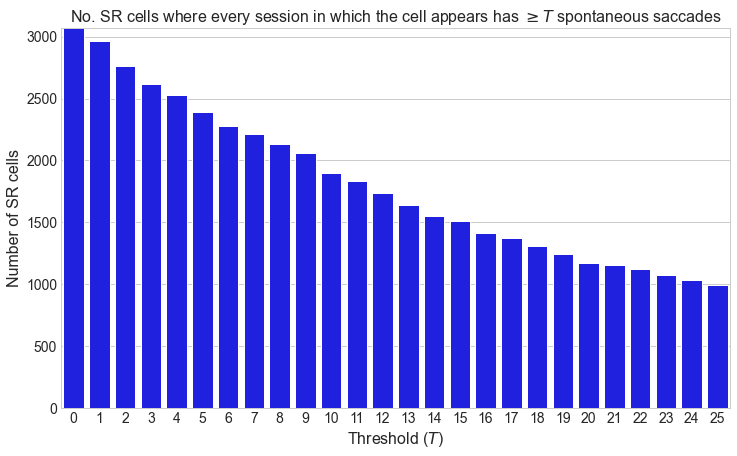

In [6]:
x = list(range(0, 26))
y = []

for thresh in x:
    n = 0
    for r in cell_responses:
        n_spont = [len(s["spontaneous"]) if "spontaneous" in s else 0 for s in r["session_responses"]]
        if min(n_spont) >= thresh:
        # if sum(n_spont) >= thresh:
            n += 1
    y.append(n)
    print(f"T = {thresh}: {n} cells")
    # y.append(n / len(cell_responses)

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(12, 7))
    sns.barplot(x, y, color="blue", ax=ax)
    ax.set_title("No. SR cells where every session in which the cell appears has $\geq T$ spontaneous saccades", fontsize=16)
    ax.set_xlabel("Threshold ($T$)", fontsize=16)
    ax.set_ylabel("Number of SR cells", fontsize=16)
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=14)
    ax.set_ylim(0, y[0])

In [7]:
# if n_spontaneous_responses > threshold
# normalized_responses = {}

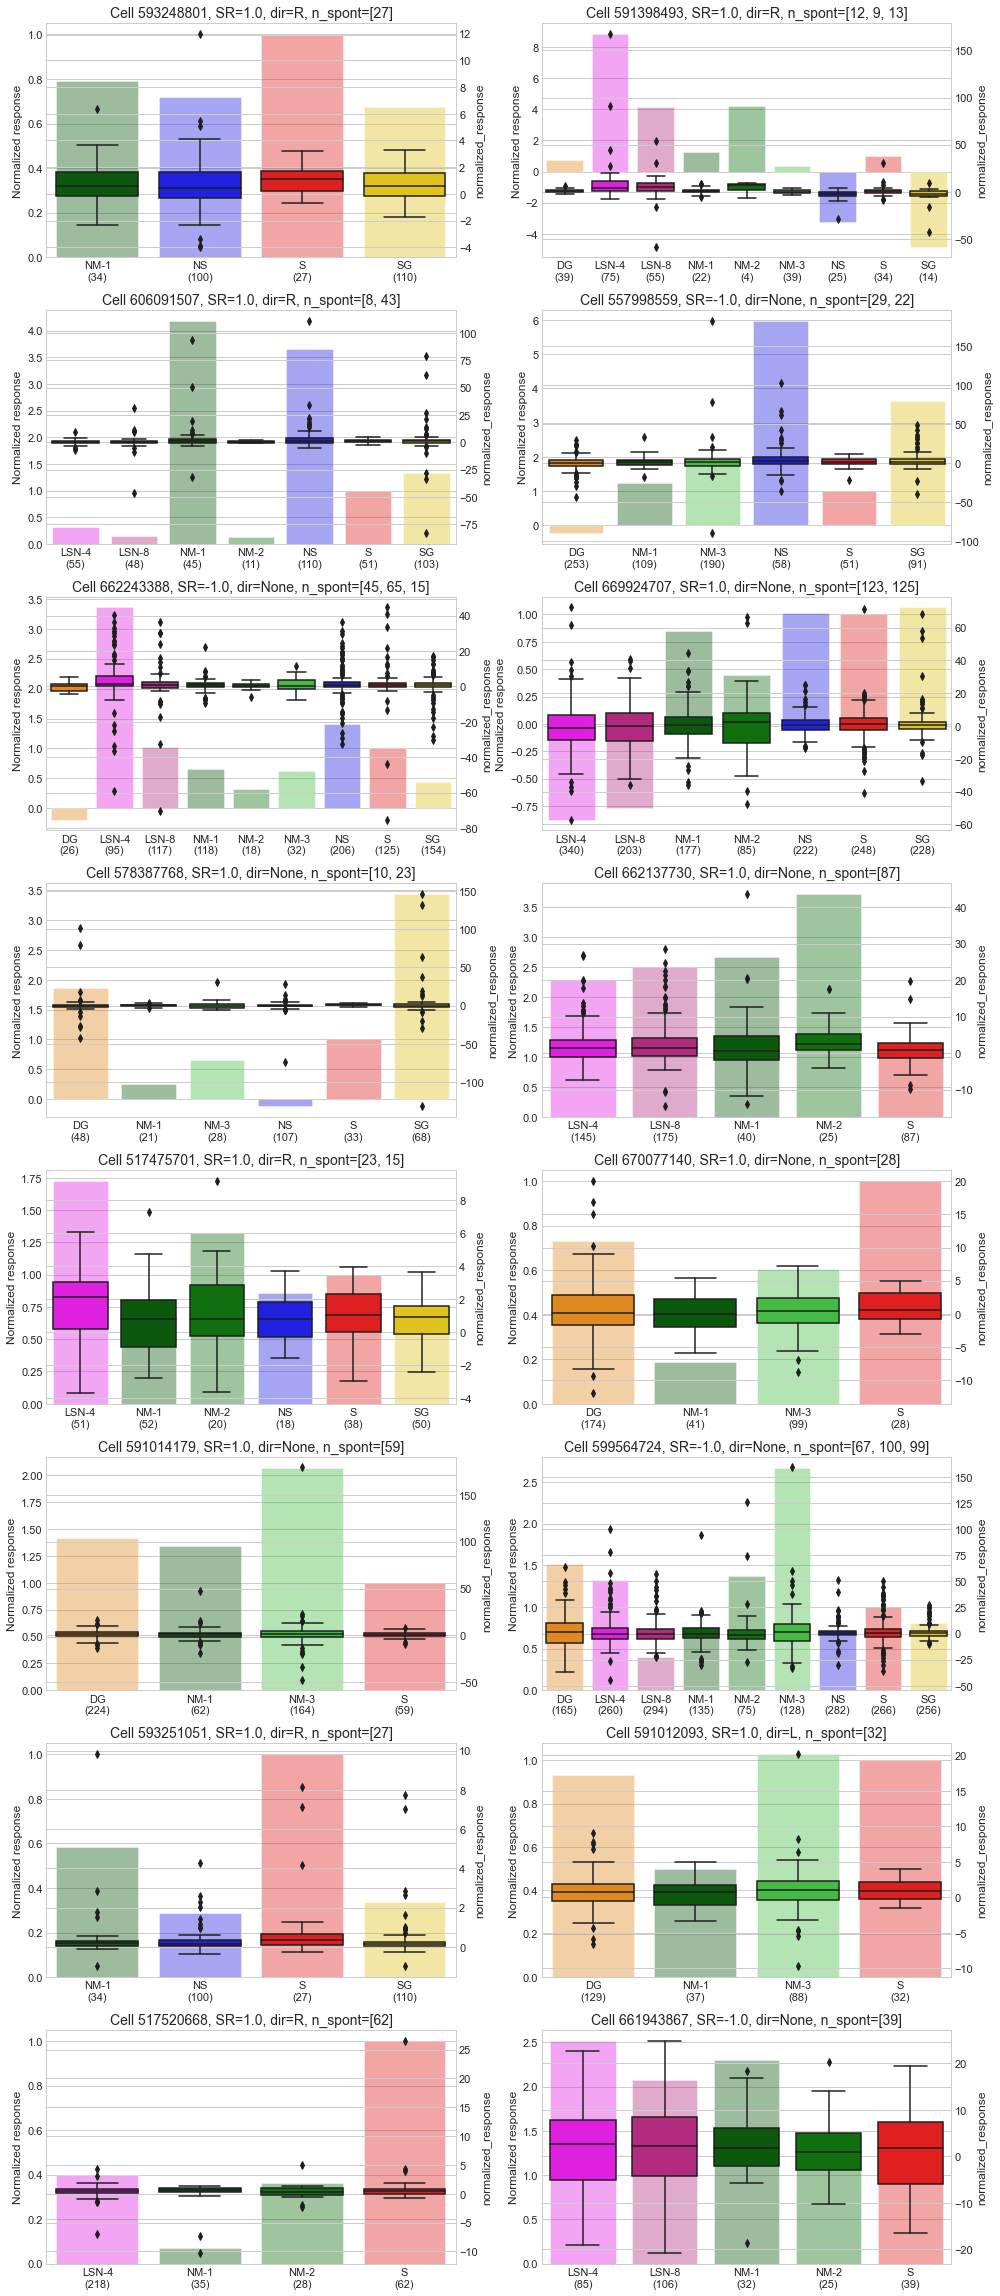

In [8]:
spont_thresh = 8

with plt.style.context("seaborn-whitegrid"):
    n_cells = 8
    fig, axs = plt.subplots(figsize=(14, 32), nrows=n_cells, ncols=2)
    proba_title = "KS on norm response"

    for ax_responses, ax_probas in np.row_stack([axs, np.column_stack([axs[:, 1], axs[:, 0]])]):
        r = None
        while True:
            r = random.choice(cell_responses)
            n_spontaneous_responses = [len(x["spontaneous"]) if "spontaneous" in x else 0 for x in r["session_responses"]]
            if min(n_spontaneous_responses) >= spont_thresh:
                break

        plt_data = []
        
        for session_response_data in r["session_responses"]:
            normalization_constant = np.mean(session_response_data["spontaneous"])

            for stim, responses in session_response_data.items():
                # if stim not in normalized_responses: normalized_responses[stim] = []
                for response in responses:
                    # normalized_responses[stim].append(response / normalization_constant)
                    plt_data.append(dict(stim=STIM_ABBREV[stim], normalized_response=(response/normalization_constant)))
        
        df = pd.DataFrame(plt_data)
        df_mean = df.groupby("stim").mean().reset_index()
        stim_order = df_mean["stim"].unique()
        sns.barplot(data=df_mean, x="stim", y="normalized_response", ax=ax_responses, palette=STIM_COLORS, alpha=0.4, order=stim_order)
        sns.boxplot(data=df, x="stim", y="normalized_response", ax=ax_responses.twinx(), palette=STIM_COLORS, order=stim_order)
        ax_responses.set_xticklabels([f"{stim}\n({(df['stim'] == stim).sum()})" for stim in stim_order])
        # ax_responses.axhline(1, color="black", linestyle="dashed", linewidth=1)
        
        ax_responses.set_title(f"Cell {r['specimen_id']}, SR={r['response_classification']}, dir={r['allowed_sacc_dir']}, n_spont={r['n_spontaneous_responses']}", fontsize=14)
        ax_responses.set_xlabel("")
        ax_responses.set_ylabel("Normalized response")

        stims = df["stim"].unique()
        p_matrix = np.zeros((len(stims), len(stims)))
        for i in range(len(stims)):
            p_matrix[i,i] = np.nan
            for j in range(i+1, len(stims)):
                p = stats.ks_2samp(df["normalized_response"][df["stim"] == stims[i]], df["normalized_response"][df["stim"] == stims[j]])[1]
                p_matrix[i,j] = p_matrix[j,i] = p

        # heatmap_log_proba_plot(p_matrix, ticklabels=stims, title=proba_title, cbar_label="p", ax=ax_probas)
        proba_title = None # Only show the title on the topmost plot
    
    fig.tight_layout()


In [9]:
fig.savefig("/Users/chase/Desktop/bystim.png")

Using test: T-test paired
LSN-4 (n = 1240) p = 0.8522
LSN-8 (n = 1124) p = 0.4829
SG (n = 1265) p = 0.9426
DG (n = 1372) p = 0.6298
NM-1 (n = 3847) p = 0.0019
NM-2 (n = 1224) p = 0.4206
NM-3 (n = 1372) p = 0.0026
NS (n = 1265) p = 0.3113


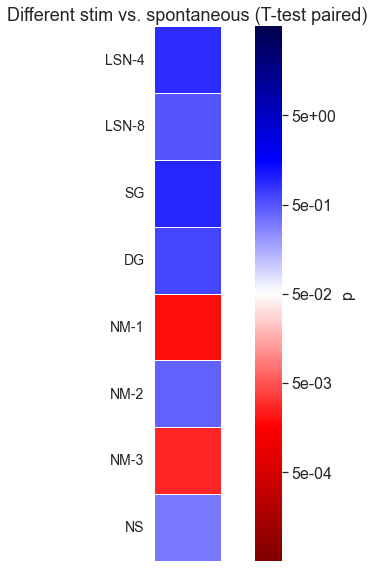

In [10]:
SPONT_THRESH = 8
stims = STIM_ORDERING[1:] # Ignore "S"
p_matrix = np.zeros((len(stims), 1))

# test_fn, test_name = stats.wilcoxon, "Wilcoxon paired"
test_fn, test_name = stats.ttest_rel, "T-test paired"
print(f"Using test: {test_name}")

for i, stim in enumerate(stims):
    spont_responses, stim_responses = [], []

    for r in cell_responses:
        n_spontaneous_responses = [len(x["spontaneous"]) if "spontaneous" in x else 0 for x in r["session_responses"]]
        
        # Ignore cells that don't have enough responses
        if min(n_spontaneous_responses) < SPONT_THRESH:
            continue

        for data in r["session_responses"]:
            for stim_full, responses in data.items():
                if STIM_ABBREV[stim_full] == stim:
                    spont_responses.append(np.mean(data["spontaneous"]))
                    stim_responses.append(np.mean(responses))
                    break

    p = test_fn(stim_responses, spont_responses)[1]
    p_matrix[i, 0] = p
    print(f"{stims[i]} (n = {len(stim_responses)}) p = {p:.4f}")
    
fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=stims, title=f"Different stim vs. spontaneous ({test_name})", cbar_label="p")
fig.tight_layout()

LSN-4 1949 3.4262013656194412e-06
LSN-8 1769 0.8432432368346038
SG 1996 8.746556090510893e-08
DG 2122 0.0005478870615432951
NM-1 5734 6.087519377473427e-10
NM-2 1731 2.7980131670712893e-05
NM-3 2114 1.2544409955239644e-12
NS 1995 4.269667064349392e-09


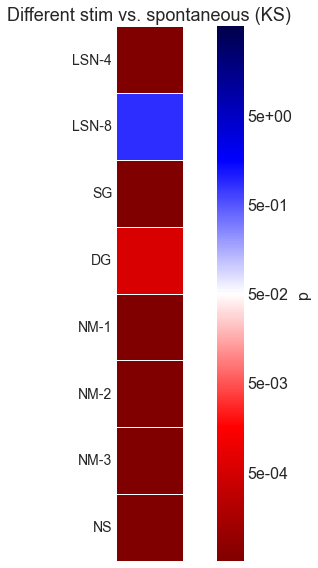

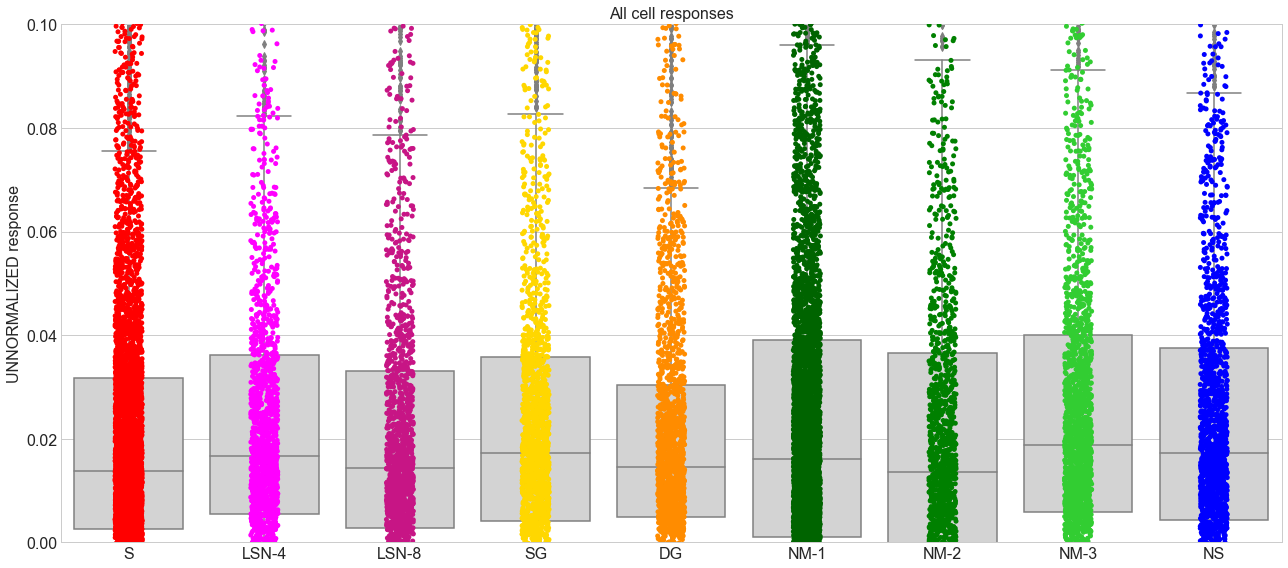

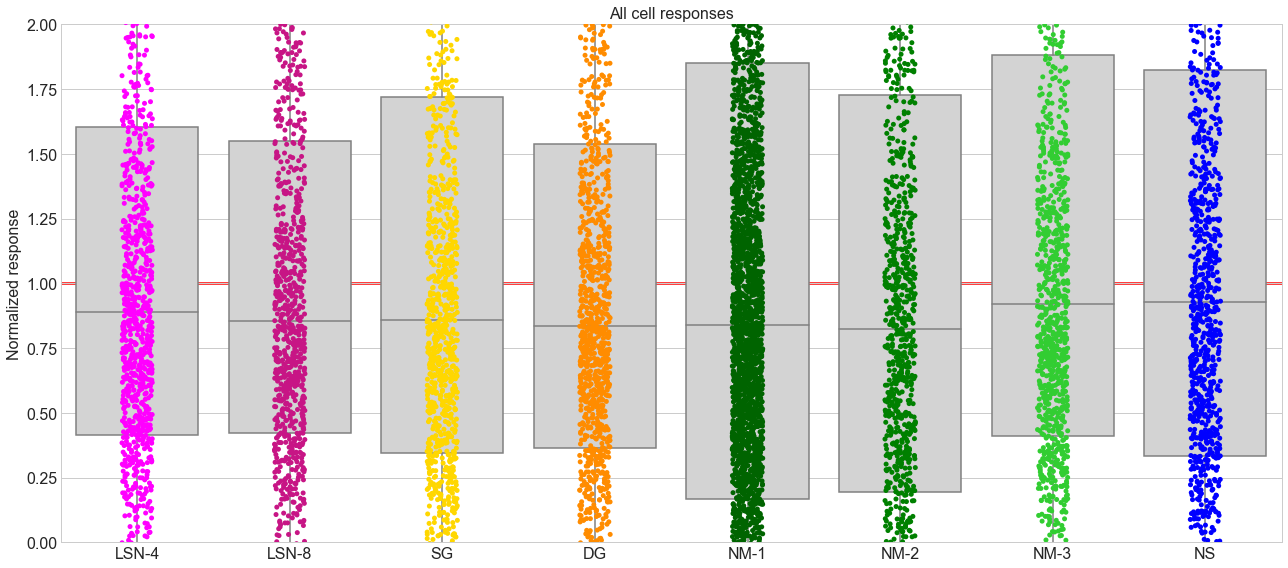

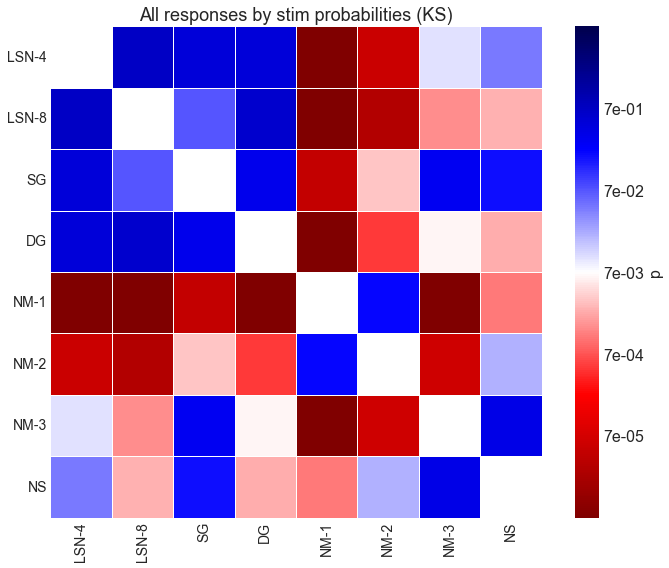

In [11]:
spont_thresh = 8

with plt.style.context("seaborn-whitegrid"):
    df = []
    df_all = []

    for r in cell_responses:
        for session_response_data in r["session_responses"]:
            for stim, responses in session_response_data.items():
                # if stim not in normalized_responses: normalized_responses[stim] = []
                mean_response = np.mean(responses)

                df_all.append({
                    CRE_PLOT_KEY: r[CRE_PLOT_KEY],
                    "stim": STIM_ABBREV[stim],
                    "targeted_structure":  r["targeted_structure"],
                    "mean_response": mean_response
                })

    for r in cell_responses:
        n_spontaneous_responses = [len(x["spontaneous"]) if "spontaneous" in x else 0 for x in r["session_responses"]]
        
        # Ignore cells that don't have enough responses
        if min(n_spontaneous_responses) < spont_thresh:
            continue
    
        # if r["response_classification"] != 1:
        #     continue

        for session_response_data in r["session_responses"]:
            normalization_constant = np.mean(session_response_data["spontaneous"])

            for stim, responses in session_response_data.items():
                # if stim not in normalized_responses: normalized_responses[stim] = []
                mean_response = np.mean(responses)

                df.append({
                    "stim": STIM_ABBREV[stim],
                    "response": mean_response,
                    "normalized_response": mean_response / normalization_constant,
                    CRE_PLOT_KEY: r[CRE_PLOT_KEY],
                    "targeted_structure":  r["targeted_structure"],
                })

    df = pd.DataFrame(df)
    df_all = pd.DataFrame(df_all)


    # Create heatmap of probabilities comparing distributions of saccade responses during each stimulus vs. spontaneous
    stims = STIM_ORDERING[1:] # Ignore "S"
    p_matrix = np.zeros((len(stims), 1))
    spont_responses = df_all["mean_response"][df_all["stim"] == "S"]
    for i in range(len(stims)):
        stim_responses = df_all["mean_response"][df_all["stim"] == stims[i]]
        p = stats.ks_2samp(stim_responses, spont_responses)[1]
        # p = stats.ranksums(stim_responses, spont_responses)[1]
        p_matrix[i, 0] = p
        print(stims[i], len(stim_responses), p)
    fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=stims, title="Different stim vs. spontaneous (KS)", cbar_label="p")
    fig.tight_layout()
    fig.savefig("/Users/chase/Desktop/all_stim_vs_spont.png")



    fig, ax = plt.subplots(figsize=(18, 8))
    sns.stripplot(data=df_all, x="stim", y="mean_response", ax=ax, palette=STIM_COLORS, order=STIM_ORDERING)
    sns.boxplot(data=df_all, x="stim", y="mean_response", ax=ax, color="lightgray", order=STIM_ORDERING)
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=16)
    ax.set_title(f"All cell responses", fontsize=16)
    ax.set_xlabel("")
    ax.set_ylabel("UNNORMALIZED response", fontsize=16)
    ax.set_ylim(0, 0.1)
    fig.tight_layout()
    fig.savefig("/Users/chase/Desktop/all_unnormalized_responses_by_stim.png")



    fig, ax = plt.subplots(figsize=(18, 8))
    sns.stripplot(data=df, x="stim", y="normalized_response", ax=ax, palette=STIM_COLORS, order=STIM_ORDERING[1:]) # Ignore S
    sns.boxplot(data=df, x="stim", y="normalized_response", ax=ax, color="lightgray", order=STIM_ORDERING[1:])
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=16)
    ax.set_title(f"All cell responses", fontsize=16)
    ax.set_xlabel("")
    ax.set_ylabel("Normalized response", fontsize=16)
    ax.set_ylim(0, 2)
    ax.axhline(1, color="red", linestyle="solid", linewidth=2.5, zorder=0)
    fig.tight_layout()
    fig.savefig("/Users/chase/Desktop/all_responses_by_stim.png")

    stims = STIM_ORDERING[1:] # Ignore "S"
    p_matrix = np.zeros((len(stims), len(stims)))
    for i in range(len(stims)):
        p_matrix[i,i] = np.nan
        for j in range(i+1, len(stims)):
            p = stats.ks_2samp(df["normalized_response"][df["stim"] == stims[i]], df["normalized_response"][df["stim"] == stims[j]])[1]
            p_matrix[i,j] = p_matrix[j,i] = p
    fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=stims, title="All responses by stim probabilities (KS)", cbar_label="p")
    fig.tight_layout()
    fig.savefig("/Users/chase/Desktop/all_responses_by_stim_probas.png")


    # df_nm1 = df[df["stim"] == "NM-1"]

    # fig, ax = plt.subplots(figsize=(18, 8))
    # sns.boxplot(data=df_nm1, x=CRE_PLOT_KEY, y="normalized_response", ax=ax, palette=CRE_COLORS, order=CRE_ORDERING)
    # plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=16)
    # plt.setp(ax.get_xticklabels(), rotation=45)
    # ax.set_title("NM-1 cell responses by transgenic line", fontsize=16)
    # ax.set_xlabel("")
    # ax.set_ylabel("Normalized response", fontsize=16)
    # ax.set_ylim(-12, 12)
    # ax.axhline(1, color="red", linestyle="solid", linewidth=1.5)
    # fig.tight_layout()
    # fig.savefig("/Users/chase/Desktop/nm1_cell_responses_by_cre.png")

    # lines = CRE_ORDERING # df_nm1[CRE_PLOT_KEY].unique()
    # p_matrix = np.zeros((len(lines), len(lines)))
    # for i in range(len(lines)):
    #     p_matrix[i,i] = np.nan
    #     for j in range(i+1, len(lines)):
    #         p = stats.ks_2samp(df_nm1["normalized_response"][df_nm1[CRE_PLOT_KEY] == lines[i]], df_nm1["normalized_response"][df_nm1[CRE_PLOT_KEY] == lines[j]])[1]
    #         p_matrix[i,j] = p_matrix[j,i] = p
    # fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=lines, title="NM1 responses by cre probabilities (KS)", cbar_label="p")
    # fig.tight_layout()
    # fig.savefig("/Users/chase/Desktop/nm1_cell_responses_by_cre_probas.png")

    # fig, ax = plt.subplots(figsize=(18, 8))
    # sns.boxplot(data=df_nm1, x="targeted_structure", y="normalized_response", ax=ax)
    # plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=16)
    # plt.setp(ax.get_xticklabels(), rotation=45)
    # ax.set_title(f"NM-1 cell responses by area", fontsize=16)
    # ax.set_xlabel("")
    # ax.set_ylabel("Normalized response", fontsize=16)
    # ax.set_ylim(-15, 15)
    # ax.axhline(1, color="gray", linestyle="solid", linewidth=1.5)
    # fig.tight_layout()
    # fig.savefig("/Users/chase/Desktop/nm1_cell_responses_by_area.png")
